# SOM analysis of NPJ

#### In this notebook, an articificla neural network (i.e., the self-organizing map or SOM) is trained using ERA5 reanalysis data to identify the relationship between the largescale circulation over the North Pacific and heavy rainfall in Hawaii.

#### Once this relationship is established, CMIP6 climate model output is projected onto the model to better understand how this relationship may change in a future climate

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import xarray as xr
import pandas as pd
import statistics

## Load and pre-process training data

In [2]:
# Load in ERA5 ua250 data 1981-2010; wet season only (Nov-Apr)
#da = xr.open_dataset('/network/rit/lab/elisontimmlab_rit/kf835882/python/ERA5/hourly/era5_day_ua250_1981-2010.nc')
da = xr.open_dataset('/network/rit/lab/elisontimmlab_rit/kf835882/python/ERA5/hourly/era5_day_ua250_1990-2010_low_res.nc')

In [3]:
# Select years 1990-2010
da = da.sel(time=slice('1990-01-01', '2010-12-31'))

In [4]:
# Calculate monthly climatologies
mon_clim = da.groupby('time.month').mean('time')

In [5]:
# Store monthly clim as variables
jan_clim = mon_clim.u[0]
feb_clim = mon_clim.u[1]
mar_clim = mon_clim.u[2]
apr_clim = mon_clim.u[3]
nov_clim = mon_clim.u[4]
dec_clim = mon_clim.u[5]

In [6]:
# Group daily wind data by month
jan_day = da.groupby('time.month')[1]
feb_day = da.groupby('time.month')[2]
mar_day = da.groupby('time.month')[3]
apr_day = da.groupby('time.month')[4]
nov_day = da.groupby('time.month')[11]
dec_day = da.groupby('time.month')[12]

In [7]:
# Remove monthly climatologies
jan_anom = jan_day.u - jan_clim
feb_anom = feb_day.u - feb_clim
mar_anom = mar_day.u - mar_clim
apr_anom = apr_day.u - apr_clim
nov_anom = nov_day.u - nov_clim
dec_anom = dec_day.u - dec_clim

In [8]:
# Merge dataarrays into one
# dim='time' keeps dates in order
ua_anom = xr.concat([jan_anom,feb_anom,mar_anom,apr_anom,nov_anom,dec_anom],dim='time')

In [9]:
ua_anom.time

<xarray.DataArray 'time' (time: 3806)> Size: 30kB
array(['1990-01-01T11:30:00.000000000', '1990-01-02T11:30:00.000000000',
       '1990-01-03T11:30:00.000000000', ..., '2010-12-29T11:30:00.000000000',
       '2010-12-30T11:30:00.000000000', '2010-12-31T11:30:00.000000000'],
      dtype='datetime64[ns]')
Coordinates:
  * time     (time) datetime64[ns] 30kB 1990-01-01T11:30:00 ... 2010-12-31T11...
    month    (time) int64 30kB 1 1 1 1 1 1 1 1 1 ... 12 12 12 12 12 12 12 12 12
Attributes:
    standard_name:  time
    long_name:      time
    bounds:         time_bnds
    axis:           T

In [10]:
# Sort the wind anomalies so they are in order by date
ua_anom = ua_anom.sortby('time',ascending=True)

In [11]:
ua_anom.shape

(3806, 35, 61)

In [12]:
# Get lat/lon info and convert to np arrays
lat = ua_anom.lat.values
lon = ua_anom.lon.values
ua = ua_anom.values

In [13]:
# Get variance of original dataset
data1d = np.reshape(ua, (ua.shape[0]*ua.shape[1]*ua.shape[2]), order = 'F')
var = statistics.variance(data1d)
print('Variance of unlabeled wind anomaly data: '+str(var))

Variance of unlabeled wind anomaly data: 148.58607


In [14]:
# Weight grid cells by cosine of latitude
latitude = np.linspace(lat.min(), lat.max(), len(lat))
weights_array = np.cos(np.deg2rad(latitude))[:, np.newaxis]

ua=ua*weights_array

In [15]:
ua.shape

(3806, 35, 61)

In [16]:
# Reshape data into time-space format
data = np.reshape(ua, (ua.shape[0], ua.shape[1]*ua.shape[2]), order = 'F')

In [17]:
data.shape

(3806, 2135)

In [18]:
t = ua_anom.time

In [19]:
# Split data into training and test set
from sklearn.model_selection import train_test_split

data_train, data_test, t_train, t_test = train_test_split(data, t, test_size=0.2, random_state=12345)

In [20]:
all_data=data_train

### Train the SOM and tune parameters (e.g., radius=2, learning rate=0.5, grid size=4x3)

In [21]:
from minisom import MiniSom

In [45]:
# Initialize and train SOM
sigma=2
learning_rate=0.5
m=4
n=3

som = MiniSom(m, n, all_data.shape[1], sigma=sigma, learning_rate=learning_rate)
som.train(all_data, 1000, verbose=True) # trains the SOM with 1000 iterations

 [ 1000 / 1000 ] 100% - 0:00:00 left 
 quantization error: 384.3542781202883


### Get topographic error

In [46]:
# Get topographic error
t_error = som.topographic_error(all_data)
t_error

np.float64(0.07884362680683311)

### Plot frequencies of each node pattern

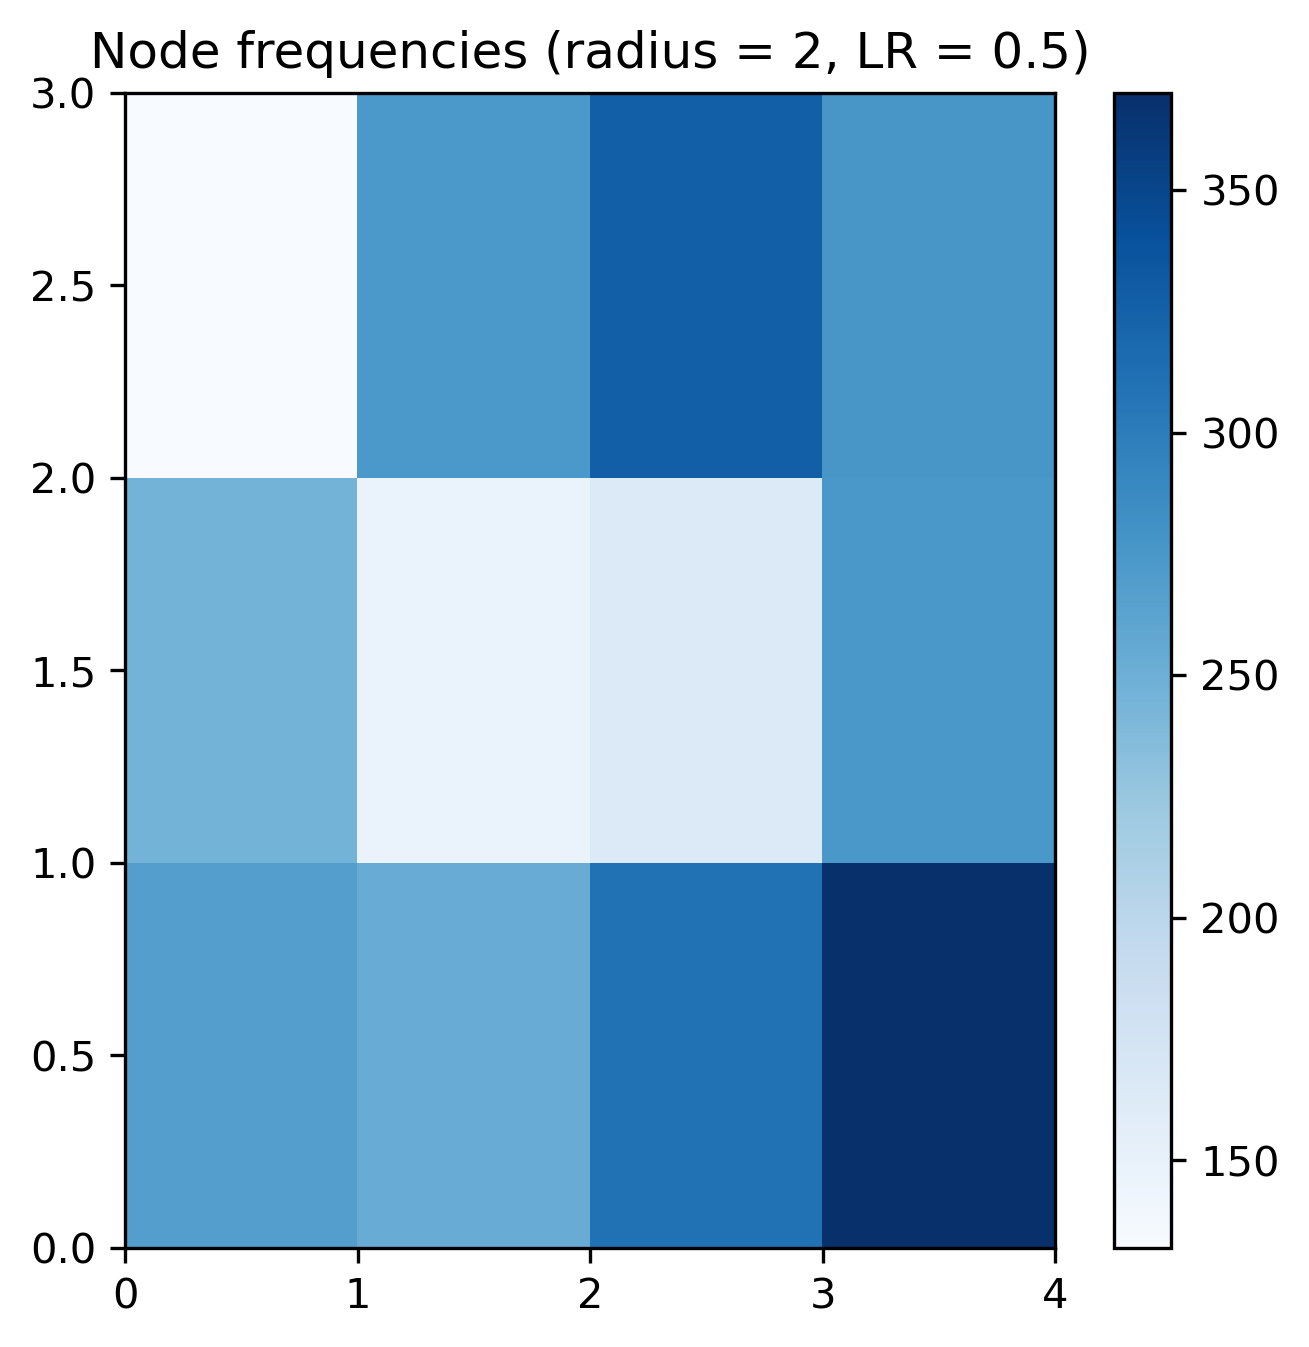

In [47]:
# Plot frequencies for each node
plt.figure(figsize=(5, 5),dpi=300)
frequencies = som.activation_response(all_data)
plt.pcolor(frequencies.T, cmap='Blues') 
plt.colorbar()
plt.title('Node frequencies (radius = '+str(sigma)+', LR = '+str(learning_rate)+')')
#plt.savefig('node_freq_unlabeled.png')
plt.show()

In [48]:
win_maps = som.win_map(all_data)

In [49]:
win_maps_array = np.zeros(shape=(m*n,ua.shape[1]*ua.shape[2]))

k=0
for i in range(0,frequencies.shape[0]):
    for j in range(0,frequencies.shape[1]):
        print(i,j)
        win_map_mean = np.mean(win_maps[i,j], axis=0)
        win_maps_array[k]=win_map_mean
        k+=1

0 0
0 1
0 2
1 0
1 1
1 2
2 0
2 1
2 2
3 0
3 1
3 2


### Plot Sammon map - which gives a representation of the mean euclidean distance between node patterns

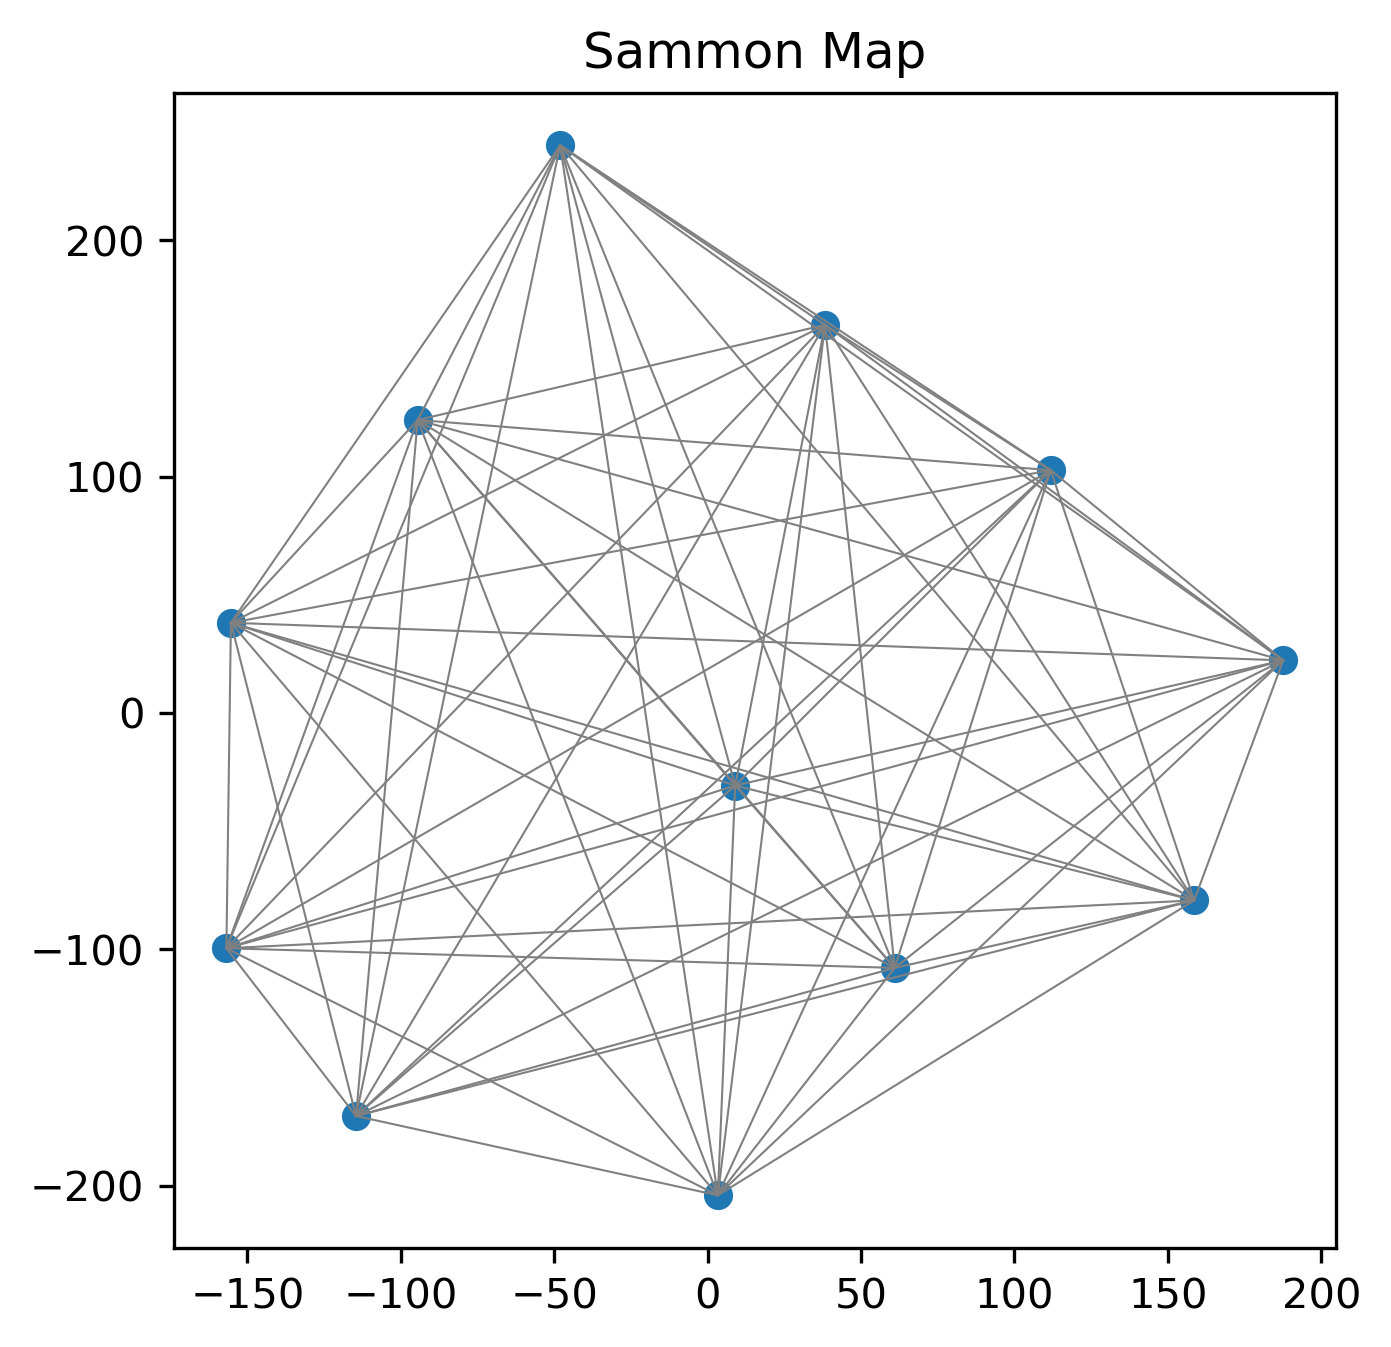

In [50]:
from sklearn.manifold import MDS

X = win_maps_array

# Apply Sammon mapping
mds = MDS(n_components=2, metric=True,normalized_stress='auto',dissimilarity='euclidean')
X_sammon = mds.fit_transform(X)

# Plot the results
import matplotlib.pyplot as plt
plt.figure(figsize=(5, 5),dpi=300)
plt.scatter(X_sammon[:, 0], X_sammon[:, 1])

for i in range(X_sammon.shape[0]):
    for j in range(i + 1, X_sammon.shape[0]):
        plt.plot([X_sammon[i, 0], X_sammon[j, 0]], [X_sammon[i, 1], X_sammon[j, 1]], color='gray', linestyle='-', linewidth=0.5)

plt.title('Sammon Map')
plt.show()

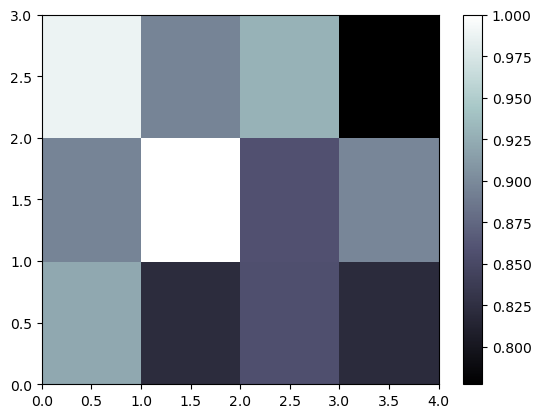

In [51]:
# Plot distances between each node and its neighbors
from pylab import plot,axis,show,pcolor,colorbar,bone
bone()
pcolor(som.distance_map(scaling='mean').T)
colorbar()

In [52]:
# Get euclidean distances between each node and its neighbors
# A mean euclidean distance closer to 1 indicates that the node patterns are different, a desired property of the SOM
distances = som.distance_map(scaling='mean')
distances.mean()

np.float64(0.8882015863268539)

In [53]:
# Save daily maps associated with each node
for i in range(0,frequencies.shape[0]):
    for j in range(0,frequencies.shape[1]):
        print(i,j)
        # Calculate mean of all samples for each node
        if int(len(win_maps[i,j])) > 0:
            win_map_mean = np.mean(win_maps[i,j], axis=0)
    
            # Reshape into plottable format
            win_map = np.reshape(win_map_mean, (ua.shape[1],ua.shape[2]), order = 'F')
        
            np.save('/network/rit/lab/elisontimmlab_rit/kf835882/python/ERA5/hourly/win_map_'+str(i)+'_'+str(j)+'_unlabeled.npy', win_map)
            #np.save('/network/rit/lab/elisontimmlab_rit/kf835882/python/ERA5/hourly/win_map_'+str(i)+'_'+str(j)+'_unlabeled_lr.npy', win_map)

0 0
0 1
0 2
1 0
1 1
1 2
2 0
2 1
2 2
3 0
3 1
3 2


In [54]:
# Save winning node location for each time step
winning_nodes = np.zeros(shape=(len(all_data),2))
i = 0
for n in range(0,len(all_data)):
    winning_nodes[i] = som.winner(all_data[n])
    i+=1

# You might want to save to a different path    
np.save('/network/rit/lab/elisontimmlab_rit/kf835882/python/ERA5/hourly/winning_nodes_unlabeled.npy', winning_nodes)
#np.save('/network/rit/lab/elisontimmlab_rit/kf835882/python/ERA5/hourly/winning_nodes_unlabeled_lr.npy', winning_nodes)

In [55]:
winners=np.load('/network/rit/lab/elisontimmlab_rit/kf835882/python/ERA5/hourly/winning_nodes_unlabeled.npy')
#winners=np.load('/network/rit/lab/elisontimmlab_rit/kf835882/python/ERA5/hourly/winning_nodes_unlabeled_lr.npy')

In [56]:
winners_list = winners.tolist()

In [57]:
# Because we randomly split the test/train data, the dates are out of order
# Use the training dates to sort the winners by date
for i in range(len(winners_list)):
    winners_list[i].append(t_train[i])

In [58]:
sorted_list = sorted(winners_list, key=lambda x: x[-1])

In [59]:
winners_list = [sublist[:-1] for sublist in sorted_list]

In [60]:
np.save('/network/rit/lab/elisontimmlab_rit/kf835882/python/ERA5/hourly/winners_sorted.npy',np.array(winners_list))
#np.save('/network/rit/lab/elisontimmlab_rit/kf835882/python/ERA5/hourly/winners_sorted_lr.npy',np.array(winners_list))

In [61]:
np.save('/network/rit/lab/elisontimmlab_rit/kf835882/python/ERA5/hourly/t_train_sorted.npy',t_train.sortby('time'))
#np.save('/network/rit/lab/elisontimmlab_rit/kf835882/python/ERA5/hourly/t_train_sorted_lr.npy',t_train.sortby('time'))

/knight/mamba_aug23/envs/sep24_env/lib/python3.12/site-packages/numpy/lib/format.py:382: UserWarning: metadata on a dtype is not saved to an npy/npz. Use another format (such as pickle) to store it.
  d['descr'] = dtype_to_descr(array.dtype)


### Calculate spatial correlation between node patterns (a well-trained SOM will have distinct node patterns)

In [62]:

# Calculate mean pattern correlation between each node and its winning days
import scipy
node_list = [[0,0],[0,1],[0,2],[1,0],[1,1],[1,2],[2,0],[2,1],[2,2],[3,0],[3,1],[3,2]]
mean_pattern_corr = np.zeros(shape=(12))

k=0
for node in node_list:
    i,j = node
    corr_list = []
    for n in range(0,len(win_maps[i,j])):
        bmu = np.mean(win_maps[i,j],axis=0)
        day = win_maps[i,j][n]
        corr = scipy.stats.pearsonr(bmu, day)
        corr_list.append(corr.statistic)
    mean = np.mean(corr_list)
    mean_pattern_corr[k] = mean
    print(node, mean)
    k+=1
     

[0, 0] 0.5120919902355188
[0, 1] 0.40464762943926663
[0, 2] 0.458630058806576
[1, 0] 0.4071971141465967
[1, 1] 0.4401639750141809
[1, 2] 0.4893270574877957
[2, 0] 0.36788082522531923
[2, 1] 0.3163558801921226
[2, 2] 0.46772603432157245
[3, 0] 0.4206082735878588
[3, 1] 0.398028009637315
[3, 2] 0.35460881673995315


In [63]:
mean_pattern_corr.mean()

np.float64(0.419772138736173)

### Plot 12 node patterns
#### - Each node pattern represents a unique NPJ regime
#### - The SOM is spatially organized so that similar node patterns are close together, while distinct node patterns are further apart

In [64]:
import cartopy.crs as ccrs
import cartopy.feature as cfeature

In [65]:
import matplotlib.colors as colors

class MidpointNormalize(colors.Normalize):
    def __init__(self, vmin=None, vmax=None, midpoint=None, clip=False):
        self.midpoint = midpoint
        colors.Normalize.__init__(self, vmin, vmax, clip)

    def __call__(self, value, clip=None):
        x, y = [self.vmin, self.midpoint, self.vmax], [0, 0.5, 1]
        return np.ma.masked_array(np.interp(value, x, y))

In [66]:
# Load node patterns for plotting
node00 = np.load('/network/rit/lab/elisontimmlab_rit/kf835882/python/ERA5/hourly/win_map_0_0_unlabeled.npy')
node01 = np.load('/network/rit/lab/elisontimmlab_rit/kf835882/python/ERA5/hourly/win_map_0_1_unlabeled.npy')
node02 = np.load('/network/rit/lab/elisontimmlab_rit/kf835882/python/ERA5/hourly/win_map_0_2_unlabeled.npy')
node10 = np.load('/network/rit/lab/elisontimmlab_rit/kf835882/python/ERA5/hourly/win_map_1_0_unlabeled.npy')
node11 = np.load('/network/rit/lab/elisontimmlab_rit/kf835882/python/ERA5/hourly/win_map_1_1_unlabeled.npy')
node12 = np.load('/network/rit/lab/elisontimmlab_rit/kf835882/python/ERA5/hourly/win_map_1_2_unlabeled.npy')
node20 = np.load('/network/rit/lab/elisontimmlab_rit/kf835882/python/ERA5/hourly/win_map_2_0_unlabeled.npy')
node21 = np.load('/network/rit/lab/elisontimmlab_rit/kf835882/python/ERA5/hourly/win_map_2_1_unlabeled.npy')
node22 = np.load('/network/rit/lab/elisontimmlab_rit/kf835882/python/ERA5/hourly/win_map_2_2_unlabeled.npy')
node30 = np.load('/network/rit/lab/elisontimmlab_rit/kf835882/python/ERA5/hourly/win_map_3_0_unlabeled.npy')
node31 = np.load('/network/rit/lab/elisontimmlab_rit/kf835882/python/ERA5/hourly/win_map_3_1_unlabeled.npy')
node32 = np.load('/network/rit/lab/elisontimmlab_rit/kf835882/python/ERA5/hourly/win_map_3_2_unlabeled.npy')

<>:39: SyntaxWarning: invalid escape sequence '\c'
<>:39: SyntaxWarning: invalid escape sequence '\c'
<>:39: SyntaxWarning: invalid escape sequence '\c'
<>:39: SyntaxWarning: invalid escape sequence '\c'
<>:39: SyntaxWarning: invalid escape sequence '\c'
<>:139: SyntaxWarning: invalid escape sequence '\c'
<>:139: SyntaxWarning: invalid escape sequence '\c'
<>:139: SyntaxWarning: invalid escape sequence '\c'
<>:139: SyntaxWarning: invalid escape sequence '\c'
<>:139: SyntaxWarning: invalid escape sequence '\c'
<>:239: SyntaxWarning: invalid escape sequence '\c'
<>:239: SyntaxWarning: invalid escape sequence '\c'
<>:239: SyntaxWarning: invalid escape sequence '\c'
<>:239: SyntaxWarning: invalid escape sequence '\c'
<>:239: SyntaxWarning: invalid escape sequence '\c'
<>:240: SyntaxWarning: invalid escape sequence '\c'
<>:240: SyntaxWarning: invalid escape sequence '\c'
<>:240: SyntaxWarning: invalid escape sequence '\c'
<>:265: SyntaxWarning: invalid escape sequence '\c'
<>:265: SyntaxWar

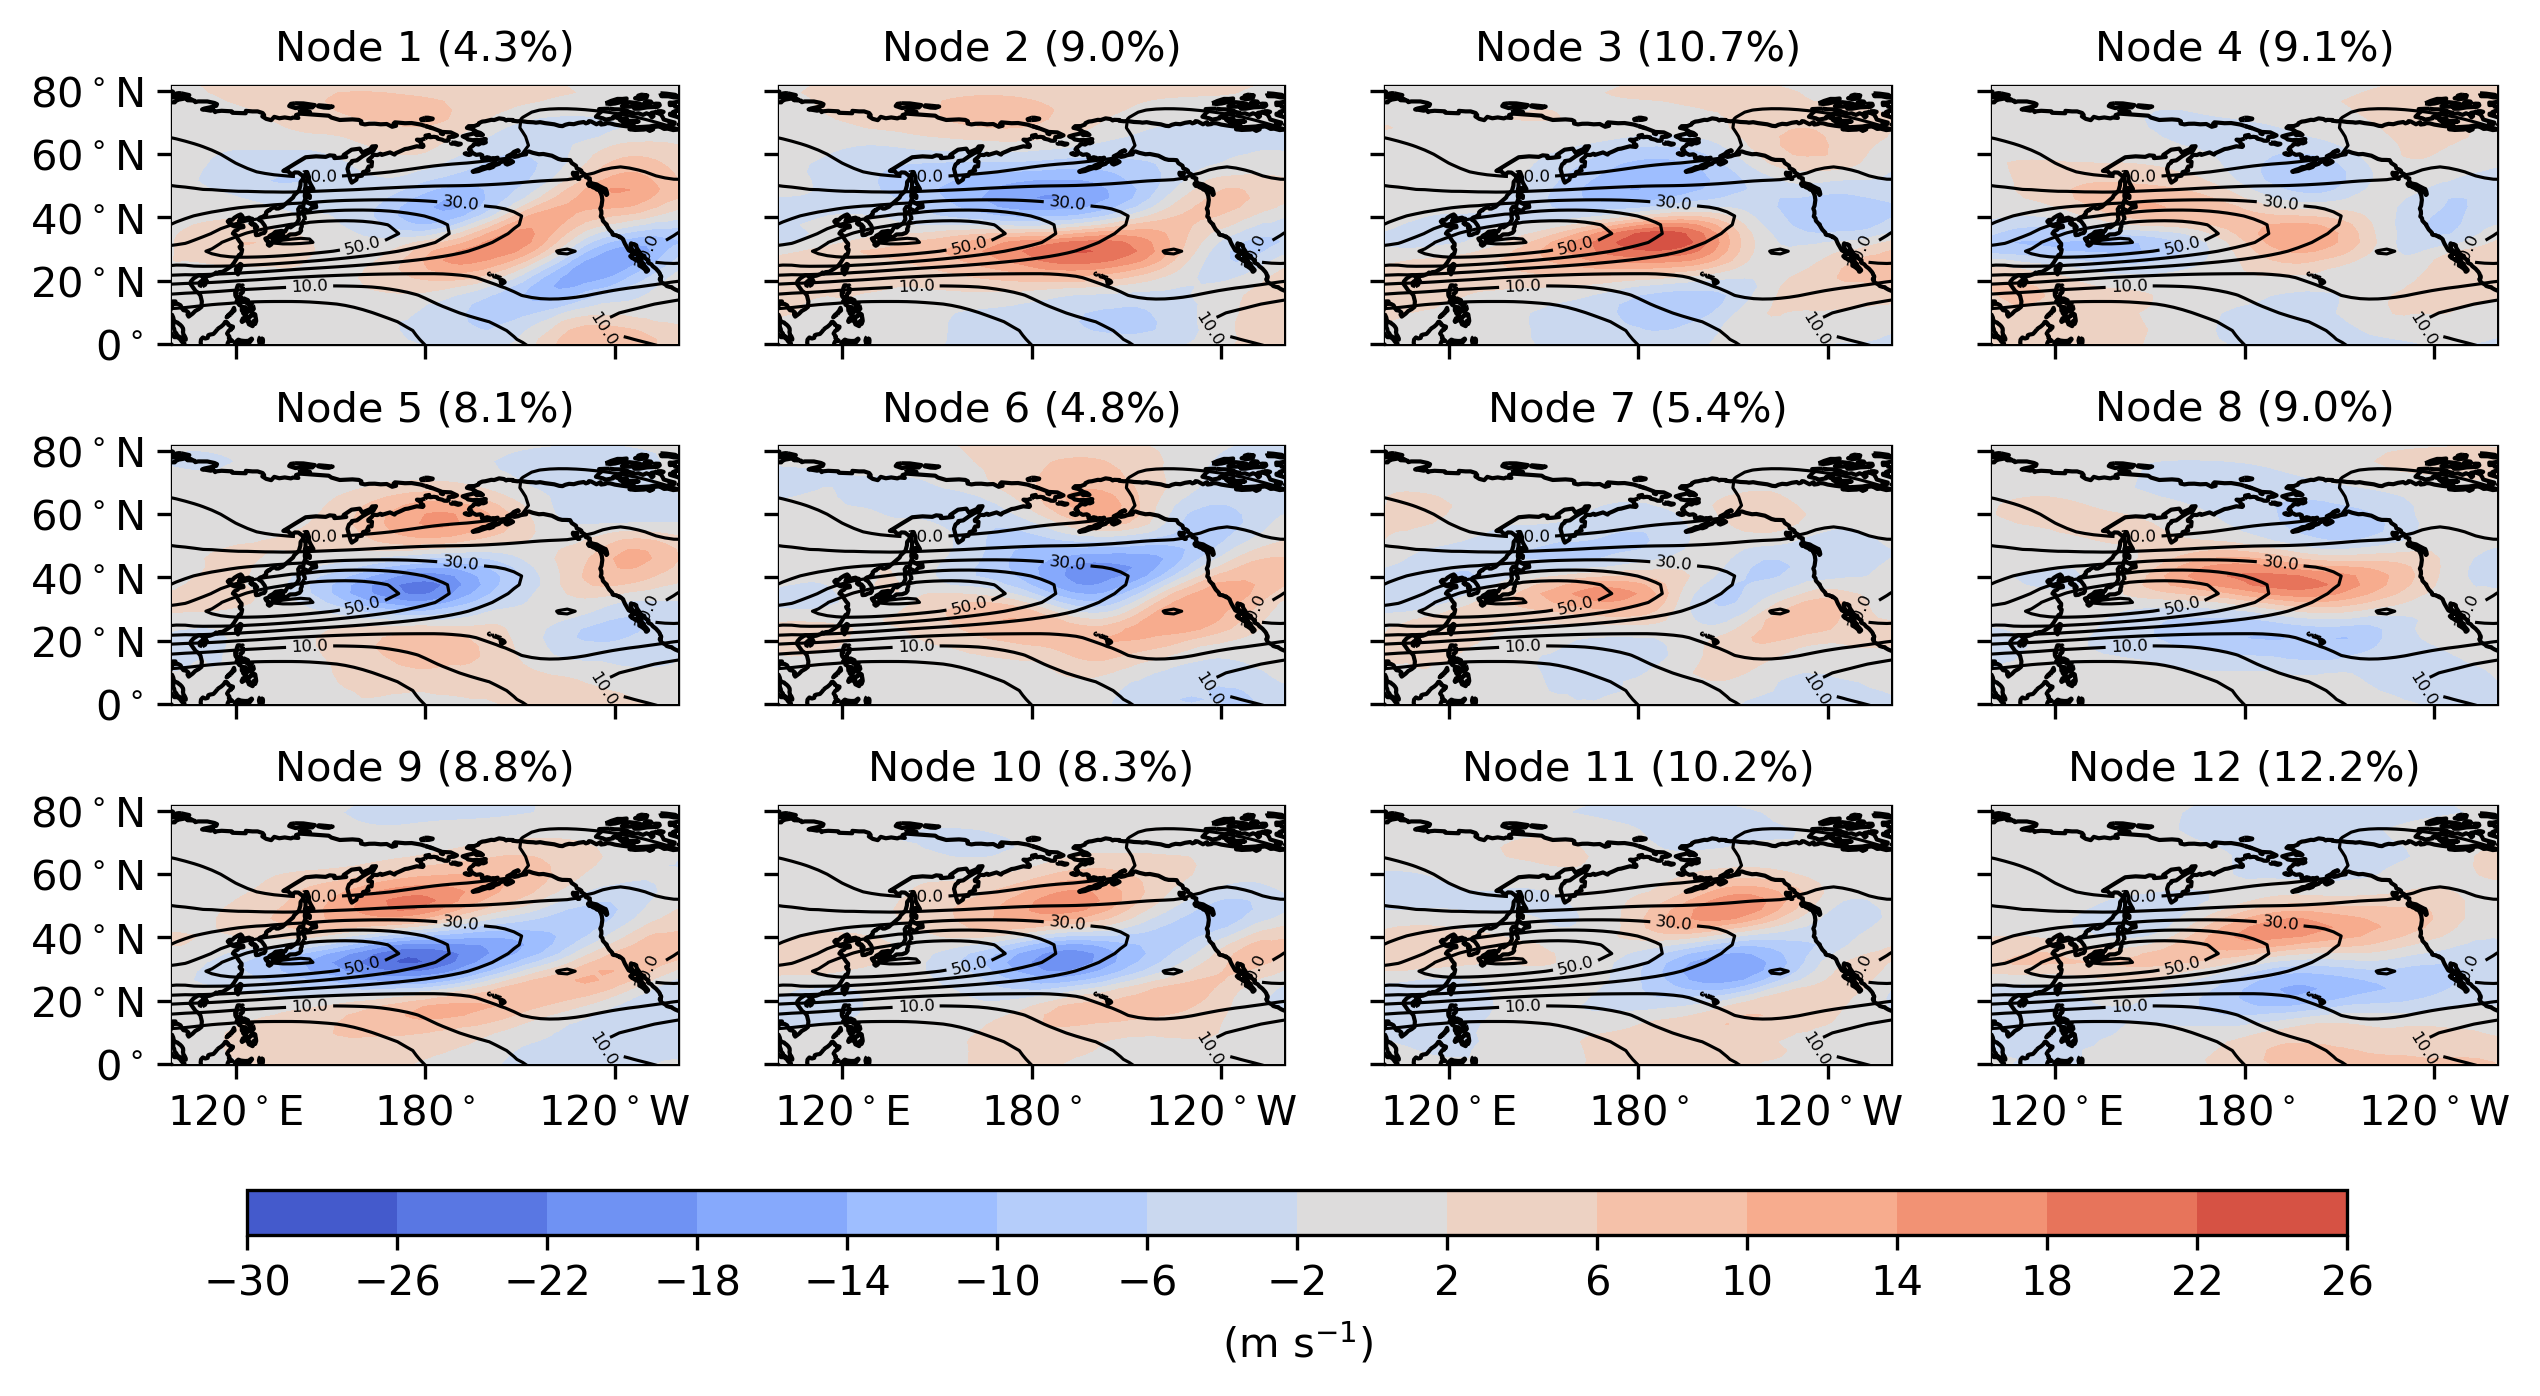

In [67]:
# Make figure
fig = plt.figure(figsize=(10,5), dpi=300)
data_crs = ccrs.PlateCarree()

central_lat = 15
central_lon = 210
extent = [100, 260, 0, 50]

size = 10
vmin = -30
vmax = 30
level = np.arange(vmin,vmax,4)

ax1 = plt.subplot(3,4,1,projection=ccrs.PlateCarree(central_lon))
#ax1 = plt.axes(projection=ccrs.PlateCarree(central_lon))
ax1.set_extent(extent)

land = cfeature.NaturalEarthFeature(category='physical', name='land', scale='50m',
                                    facecolor=cfeature.COLORS['land'])
ocean = cfeature.NaturalEarthFeature(category='physical', name='ocean', scale='50m',
                                    facecolor='gray')

ax1.add_feature(ocean,zorder=1)
ax1.add_feature(land,zorder=2)

ct=ax1.contour(lon,lat,da.u.mean(axis=0),colors='black',transform=data_crs,zorder=4,linewidths=0.75)
ax1.clabel(ct, ct.levels[::2], fmt='%1.1f',inline=True, fontsize=4)
contf=ax1.contourf(lon,lat,node02/weights_array,cmap=plt.cm.coolwarm,transform=data_crs,vmin = vmin,vmax=vmax,levels=level,norm=MidpointNormalize(midpoint=0),zorder=3)

#cbar = fig.colorbar(contf,ax=ax1, shrink=.3)
#cbar.ax.tick_params(labelsize=size)

ax1.gridlines(color="black", linestyle="dotted",linewidth = 0.5,zorder=5)
ax1.coastlines(zorder=5)
#ax1.set_xlabel("",size=size)
#ax1.set_ylabel("",size=size)
ax1.set_xticks(ticks = np.arange(-90, 60,60))
ax1.set_yticks(ticks = np.arange(0, 85,20))
ax1.set_yticklabels(labels = ['0$^\circ$','20$^\circ$N','40$^\circ$N','60$^\circ$N','80$^\circ$N'],size = size)
ax1.set_xticklabels(labels = ['','',''],size = size)
ax1.set_title('Node 1 ('+str(round(((frequencies[0,2]/len(all_data))*100),1))+'%)', size=size)


ax2 = plt.subplot(3,4,2,projection=ccrs.PlateCarree(central_lon))
#ax1 = plt.axes(projection=ccrs.PlateCarree(central_lon))
ax2.set_extent(extent)

ax2.add_feature(ocean,zorder=1)
ax2.add_feature(land,zorder=2)

ct=ax2.contour(lon,lat,da.u.mean(axis=0),colors='black',transform=data_crs,zorder=4,linewidths=0.75)
ax2.clabel(ct, ct.levels[::2], fmt='%1.1f',inline=True, fontsize=4)
contf=ax2.contourf(lon,lat,node12/weights_array,cmap=plt.cm.coolwarm,transform=data_crs,vmin = vmin,vmax=vmax,levels=level,norm=MidpointNormalize(midpoint=0),zorder=3)

#cbar = fig.colorbar(contf,ax=ax2, shrink=.3)
#cbar.ax.tick_params(labelsize=size)

ax2.gridlines(color="black", linestyle="dotted",linewidth = 0.5,zorder=5)
ax2.coastlines(zorder=5)
#ax2.set_xlabel("",size=size)
#ax2.set_ylabel("",size=size)
ax2.set_xticks(ticks = np.arange(-90, 60,60))
ax2.set_yticks(ticks = np.arange(0, 85,20))
ax2.set_yticklabels(labels = ['','','','',''],size = size)
ax2.set_xticklabels(labels = ['','',''],size = size)
ax2.set_title('Node 2 ('+str(round(((frequencies[1,2]/len(all_data))*100),1))+'%)', size=size)


ax3 = plt.subplot(3,4,3,projection=ccrs.PlateCarree(central_lon))
#ax1 = plt.axes(projection=ccrs.PlateCarree(central_lon))
ax3.set_extent(extent)

ax3.add_feature(ocean,zorder=1)
ax3.add_feature(land,zorder=2)

ct=ax3.contour(lon,lat,da.u.mean(axis=0),colors='black',transform=data_crs,zorder=4,linewidths=0.75)
ax3.clabel(ct, ct.levels[::2], fmt='%1.1f',inline=True, fontsize=4)
contf=ax3.contourf(lon,lat,node22/weights_array,cmap=plt.cm.coolwarm,transform=data_crs,vmin = vmin,vmax=vmax,levels=level,norm=MidpointNormalize(midpoint=0),zorder=3)

#cbar = fig.colorbar(contf,ax=ax3, shrink=.3)
#cbar.ax.tick_params(labelsize=size)

ax3.gridlines(color="black", linestyle="dotted",linewidth = 0.5,zorder=5)
ax3.coastlines(zorder=5)
#ax3.set_xlabel("",size=size)
#ax3.set_ylabel("",size=size)
ax3.set_xticks(ticks = np.arange(-90, 60,60))
ax3.set_yticks(ticks = np.arange(0, 85,20))
ax3.set_yticklabels(labels = ['','','','',''],size = size)
ax3.set_xticklabels(labels = ['','',''],size = size)
ax3.set_title('Node 3 ('+str(round(((frequencies[2,2]/len(all_data))*100),1))+'%)', size=size)


ax4 = plt.subplot(3,4,4,projection=ccrs.PlateCarree(central_lon))
#ax1 = plt.axes(projection=ccrs.PlateCarree(central_lon))
ax4.set_extent(extent)

ax4.add_feature(ocean,zorder=1)
ax4.add_feature(land,zorder=2)

ct=ax4.contour(lon,lat,da.u.mean(axis=0),colors='black',transform=data_crs,zorder=4,linewidths=0.75)
ax4.clabel(ct, ct.levels[::2], fmt='%1.1f',inline=True, fontsize=4)
contf=ax4.contourf(lon,lat,node32/weights_array,cmap=plt.cm.coolwarm,transform=data_crs,vmin = vmin,vmax=vmax,levels=level,norm=MidpointNormalize(midpoint=0),zorder=3)

#cbar = fig.colorbar(contf,ax=ax4, shrink=.3)
#cbar.ax.tick_params(labelsize=size)

ax4.gridlines(color="black", linestyle="dotted",linewidth = 0.5,zorder=5)
ax4.coastlines(zorder=5)
#ax4.set_xlabel("",size=size)
#ax4.set_ylabel("",size=size)
ax4.set_xticks(ticks = np.arange(-90, 60,60))
ax4.set_yticks(ticks = np.arange(0, 85,20))
ax4.set_yticklabels(labels = ['','','','',''],size = size)
ax4.set_xticklabels(labels = ['','',''],size = size)
ax4.set_title('Node 4 ('+str(round(((frequencies[3,2]/len(all_data))*100),1))+'%)', size=size)


ax5 = plt.subplot(3,4,5,projection=ccrs.PlateCarree(central_lon))
#ax1 = plt.axes(projection=ccrs.PlateCarree(central_lon))
ax5.set_extent(extent)

ax5.add_feature(ocean,zorder=1)
ax5.add_feature(land,zorder=2)

ct=ax5.contour(lon,lat,da.u.mean(axis=0),colors='black',transform=data_crs,zorder=4,linewidths=0.75)
ax5.clabel(ct, ct.levels[::2], fmt='%1.1f',inline=True, fontsize=4)
contf=ax5.contourf(lon,lat,node01/weights_array,cmap=plt.cm.coolwarm,transform=data_crs,vmin = vmin,vmax=vmax,levels=level,norm=MidpointNormalize(midpoint=0),zorder=3)

#cbar = fig.colorbar(contf,ax=ax5, shrink=.3)
#cbar.ax.tick_params(labelsize=size)

ax5.gridlines(color="black", linestyle="dotted",linewidth = 0.5,zorder=5)
ax5.coastlines(zorder=5)
#ax5.set_xlabel("",size=size)
#ax5.set_ylabel("",size=size)
ax5.set_xticks(ticks = np.arange(-90, 60,60))
ax5.set_yticks(ticks = np.arange(0, 85,20))
ax5.set_yticklabels(labels = ['0$^\circ$','20$^\circ$N','40$^\circ$N','60$^\circ$N','80$^\circ$N'],size = size)
ax5.set_xticklabels(labels = ['','',''],size = size)
ax5.set_title('Node 5 ('+str(round(((frequencies[0,1]/len(all_data))*100),1))+'%)', size=size)


ax6 = plt.subplot(3,4,6,projection=ccrs.PlateCarree(central_lon))
#ax1 = plt.axes(projection=ccrs.PlateCarree(central_lon))
ax6.set_extent(extent)

ax6.add_feature(ocean,zorder=1)
ax6.add_feature(land,zorder=2)

ct=ax6.contour(lon,lat,da.u.mean(axis=0),colors='black',transform=data_crs,zorder=4,linewidths=0.75)
ax6.clabel(ct, ct.levels[::2], fmt='%1.1f',inline=True, fontsize=4)
contf=ax6.contourf(lon,lat,node11/weights_array,cmap=plt.cm.coolwarm,transform=data_crs,vmin = vmin,vmax=vmax,levels=level,norm=MidpointNormalize(midpoint=0),zorder=3)

#cbar = fig.colorbar(contf,ax=ax6, shrink=.3)
#cbar.ax.tick_params(labelsize=size)

ax6.gridlines(color="black", linestyle="dotted",linewidth = 0.5,zorder=5)
ax6.coastlines(zorder=5)
#ax6.set_xlabel("",size=size)
#ax6.set_ylabel("",size=size)
ax6.set_xticks(ticks = np.arange(-90, 60,60))
ax6.set_yticks(ticks = np.arange(0, 85,20))
ax6.set_yticklabels(labels = ['','','','',''],size = size)
ax6.set_xticklabels(labels = ['','',''],size = size)
ax6.set_title('Node 6 ('+str(round(((frequencies[1,1]/len(all_data))*100),1))+'%)', size=size)


ax7 = plt.subplot(3,4,7,projection=ccrs.PlateCarree(central_lon))
#ax1 = plt.axes(projection=ccrs.PlateCarree(central_lon))
ax7.set_extent(extent)

ax7.add_feature(ocean,zorder=1)
ax7.add_feature(land,zorder=2)

ct=ax7.contour(lon,lat,da.u.mean(axis=0),colors='black',transform=data_crs,zorder=4,linewidths=0.75)
ax7.clabel(ct, ct.levels[::2], fmt='%1.1f',inline=True, fontsize=4)
contf=ax7.contourf(lon,lat,node21/weights_array,cmap=plt.cm.coolwarm,transform=data_crs,vmin = vmin,vmax=vmax,levels=level,norm=MidpointNormalize(midpoint=0),zorder=3)

#cbar = fig.colorbar(contf,ax=ax7, shrink=.3)
#cbar.ax.tick_params(labelsize=size)

ax7.gridlines(color="black", linestyle="dotted",linewidth = 0.5,zorder=5)
ax7.coastlines(zorder=5)
#ax7.set_xlabel("",size=size)
#ax7.set_ylabel("",size=size)
ax7.set_xticks(ticks = np.arange(-90, 60,60))
ax7.set_yticks(ticks = np.arange(0, 85,20))
ax7.set_yticklabels(labels = ['','','','',''],size = size)
ax7.set_xticklabels(labels = ['','',''],size = size)
ax7.set_title('Node 7 ('+str(round(((frequencies[2,1]/len(all_data))*100),1))+'%)', size=size)


ax8 = plt.subplot(3,4,8,projection=ccrs.PlateCarree(central_lon))
#ax1 = plt.axes(projection=ccrs.PlateCarree(central_lon))
ax8.set_extent(extent)

ax8.add_feature(ocean,zorder=1)
ax8.add_feature(land,zorder=2)

ct=ax8.contour(lon,lat,da.u.mean(axis=0),colors='black',transform=data_crs,zorder=4,linewidths=0.75)
ax8.clabel(ct, ct.levels[::2], fmt='%1.1f',inline=True, fontsize=4)
contf=ax8.contourf(lon,lat,node31/weights_array,cmap=plt.cm.coolwarm,transform=data_crs,vmin = vmin,vmax=vmax,levels=level,norm=MidpointNormalize(midpoint=0),zorder=3)

#cbar = fig.colorbar(contf,ax=ax8, shrink=.3)
#cbar.ax.tick_params(labelsize=size)

ax8.gridlines(color="black", linestyle="dotted",linewidth = 0.5,zorder=5)
ax8.coastlines(zorder=5)
#ax8.set_xlabel("",size=size)
#ax8.set_ylabel("",size=size)
ax8.set_xticks(ticks = np.arange(-90, 60,60))
ax8.set_yticks(ticks = np.arange(0, 85,20))
ax8.set_yticklabels(labels = ['','','','',''],size = size)
ax8.set_xticklabels(labels = ['','',''],size = size)
ax8.set_title('Node 8 ('+str(round(((frequencies[3,1]/len(all_data))*100),1))+'%)', size=size)


ax9 = plt.subplot(3,4,9,projection=ccrs.PlateCarree(central_lon))
#ax1 = plt.axes(projection=ccrs.PlateCarree(central_lon))
ax9.set_extent(extent)

ax9.add_feature(ocean,zorder=1)
ax9.add_feature(land,zorder=2)

ct=ax9.contour(lon,lat,da.u.mean(axis=0),colors='black',transform=data_crs,zorder=4,linewidths=0.75)
ax9.clabel(ct, ct.levels[::2], fmt='%1.1f',inline=True, fontsize=4)
contf=ax9.contourf(lon,lat,node00/weights_array,cmap=plt.cm.coolwarm,transform=data_crs,vmin = vmin,vmax=vmax,levels=level,norm=MidpointNormalize(midpoint=0),zorder=3)

#cbar = fig.colorbar(contf,ax=ax9, shrink=.3)
#cbar.ax.tick_params(labelsize=size)

ax9.gridlines(color="black", linestyle="dotted",linewidth = 0.5,zorder=5)
ax9.coastlines(zorder=5)
#ax9.set_xlabel("",size=size)
#ax9.set_ylabel("",size=size)
ax9.set_xticks(ticks = np.arange(-90, 60,60))
ax9.set_yticks(ticks = np.arange(0, 85,20))
ax9.set_yticklabels(labels = ['0$^\circ$','20$^\circ$N','40$^\circ$N','60$^\circ$N','80$^\circ$N'],size = size)
ax9.set_xticklabels(labels = ['120$^\circ$E','180$^\circ$','120$^\circ$W'],size = size)
ax9.set_title('Node 9 ('+str(round(((frequencies[0,0]/len(all_data))*100),1))+'%)', size=size)


ax10 = plt.subplot(3,4,10,projection=ccrs.PlateCarree(central_lon))
#ax1 = plt.axes(projection=ccrs.PlateCarree(central_lon))
ax10.set_extent(extent)

ax10.add_feature(ocean,zorder=1)
ax10.add_feature(land,zorder=2)

ct=ax10.contour(lon,lat,da.u.mean(axis=0),colors='black',transform=data_crs,zorder=4,linewidths=0.75)
ax10.clabel(ct, ct.levels[::2], fmt='%1.1f',inline=True, fontsize=4)
contf=ax10.contourf(lon,lat,node10/weights_array,cmap=plt.cm.coolwarm,transform=data_crs,vmin = vmin,vmax=vmax,levels=level,norm=MidpointNormalize(midpoint=0),zorder=3)

#cbar = fig.colorbar(contf,ax=ax10, shrink=.3)
#cbar.ax.tick_params(labelsize=size)

ax10.gridlines(color="black", linestyle="dotted",linewidth = 0.5,zorder=5)
ax10.coastlines(zorder=5)
#ax10.set_xlabel("",size=size)
#ax10.set_ylabel("",size=size)
ax10.set_xticks(ticks = np.arange(-90, 60,60))
ax10.set_yticks(ticks = np.arange(0, 85,20))
ax10.set_yticklabels(labels = ['','','','',''],size = size)
ax10.set_xticklabels(labels = ['120$^\circ$E','180$^\circ$','120$^\circ$W'],size = size)
ax10.set_title('Node 10 ('+str(round(((frequencies[1,0]/len(all_data))*100),1))+'%)', size=size)


ax11 = plt.subplot(3,4,11,projection=ccrs.PlateCarree(central_lon))
#ax1 = plt.axes(projection=ccrs.PlateCarree(central_lon))
ax11.set_extent(extent)

ax11.add_feature(ocean,zorder=1)
ax11.add_feature(land,zorder=2)

ct=ax11.contour(lon,lat,da.u.mean(axis=0),colors='black',transform=data_crs,zorder=4,linewidths=0.75)
ax11.clabel(ct, ct.levels[::2], fmt='%1.1f',inline=True, fontsize=4)
contf=ax11.contourf(lon,lat,node20/weights_array,cmap=plt.cm.coolwarm,transform=data_crs,vmin = vmin,vmax=vmax,levels=level,norm=MidpointNormalize(midpoint=0),zorder=3)

#cbar = fig.colorbar(contf,ax=ax11, shrink=.3)
#cbar.ax.tick_params(labelsize=size)

ax11.gridlines(color="black", linestyle="dotted",linewidth = 0.5,zorder=5)
ax11.coastlines(zorder=5)
#ax11.set_xlabel("",size=size)
#ax11.set_ylabel("",size=size)
ax11.set_xticks(ticks = np.arange(-90, 60,60))
ax11.set_yticks(ticks = np.arange(0, 85,20))
ax11.set_yticklabels(labels = ['','','','',''],size = size)
ax11.set_xticklabels(labels = ['120$^\circ$E','180$^\circ$','120$^\circ$W'],size = size)
ax11.set_title('Node 11 ('+str(round(((frequencies[2,0]/len(all_data))*100),1))+'%)', size=size)


ax12 = plt.subplot(3,4,12,projection=ccrs.PlateCarree(central_lon))
#ax1 = plt.axes(projection=ccrs.PlateCarree(central_lon))
ax12.set_extent(extent)

ax12.add_feature(ocean,zorder=1)
ax12.add_feature(land,zorder=2)

ct=ax12.contour(lon,lat,da.u.mean(axis=0),colors='black',transform=data_crs,zorder=4,linewidths=0.75)
ax12.clabel(ct, ct.levels[::2], fmt='%1.1f',inline=True, fontsize=4)
contf=ax12.contourf(lon,lat,node30/weights_array,cmap=plt.cm.coolwarm,transform=data_crs,vmin = vmin,vmax=vmax,levels=level,norm=MidpointNormalize(midpoint=0),zorder=3)

#cbar = fig.colorbar(contf,ax=ax12, shrink=.3)
#cbar.ax.tick_params(labelsize=size)

ax12.gridlines(color="black", linestyle="dotted",linewidth = 0.5,zorder=5)
ax12.coastlines(zorder=5)
#ax12.set_xlabel("",size=size)
#ax12.set_ylabel("",size=size)
ax12.set_xticks(ticks = np.arange(-90, 60,60))
ax12.set_yticks(ticks = np.arange(0, 85,20))
ax12.set_yticklabels(labels = ['','','','',''],size = size)
ax12.set_xticklabels(labels = ['120$^\circ$E','180$^\circ$','120$^\circ$W'],size = size)
ax12.set_title('Node 12 ('+str(round(((frequencies[3,0]/len(all_data))*100),1))+'%)', size=size)


fig.subplots_adjust(bottom=0.2)
cbar_ax = fig.add_axes([0.15, 0.1, 0.7, 0.03])
cbar = fig.colorbar(contf, cax=cbar_ax, ticks = np.arange(vmin, vmax, 4), orientation='horizontal', shrink = 0.60, pad = 0.0)
cbar.set_label('(m s$^{-1}$)',fontsize=size)
cbar.ax.tick_params(labelsize=size)

plt.savefig('node_patterns_unlabeled.png')
plt.show()


### Load and process CMIP6 data

In [261]:
# models=['ACCESS-CM2','BCC-CSM2-MR','CanESM5','CESM2','CMCC-CM2-SR5','CMCC-ESM2',\
#         'CNRM-CM6-1','CNRM-CM6-1-HR','CNRM-ESM2-1','IITM-ESM','IPSL-CM6A-LR','MIROC6',\
#         'MRI-ESM2-0','NorESM2-LM','NorESM2-MM','TaiESM1','EC-Earth3','EC-Earth3-Veg',\
#         'EC-Earth3-Veg-LR','MPI-ESM1-2-HR','MPI-ESM1-2-LR']

In [707]:
# Do this 10 times - ones for each member run
#path1 = '/network/rit/lab/elisontimmlab_rit/kf835882/python/CMIP6/DAMIP_test/ua250/'
path1 = '/nfs/data_snow/elisontimm/CMIP6share/'
model='MPI-ESM1-2-LR'
run='r1i1p1f1' # Change for each member

In [708]:
hist = xr.open_dataset(path1+'historical/'+model+'_historical_'+run+'_ua_NP_regridded_1990_2010_nov_apr_day_lev250.nc')
ssp = xr.open_dataset(path1+'ssp585/'+model+'_ssp585_'+run+'_ua_NP_regridded_2070_2099_nov_apr_day_lev250.nc')

/knight/mamba_aug23/envs/jan24_env/lib/python3.11/site-packages/xarray/coding/times.py:987: SerializationWarning: Unable to decode time axis into full numpy.datetime64 objects, continuing using cftime.datetime objects instead, reason: dates out of range
  dtype = _decode_cf_datetime_dtype(data, units, calendar, self.use_cftime)


In [709]:
# Calculate monthly climatologies
mon_clim_hist = hist.groupby('time.month').mean('time')
mon_clim_ssp = ssp.groupby('time.month').mean('time')

/knight/mamba_aug23/envs/jan24_env/lib/python3.11/site-packages/xarray/core/indexing.py:654: SerializationWarning: Unable to decode time axis into full numpy.datetime64 objects, continuing using cftime.datetime objects instead, reason: dates out of range
  array = array.get_duck_array()


In [710]:
# Store monthly clim as variables
jan_clim_hist = mon_clim_hist.ua[0]
feb_clim_hist = mon_clim_hist.ua[1]
mar_clim_hist = mon_clim_hist.ua[2]
apr_clim_hist = mon_clim_hist.ua[3]
nov_clim_hist = mon_clim_hist.ua[4]
dec_clim_hist = mon_clim_hist.ua[5]

jan_clim_ssp = mon_clim_ssp.ua[0]
feb_clim_ssp = mon_clim_ssp.ua[1]
mar_clim_ssp = mon_clim_ssp.ua[2]
apr_clim_ssp = mon_clim_ssp.ua[3]
nov_clim_ssp = mon_clim_ssp.ua[4]
dec_clim_ssp = mon_clim_ssp.ua[5]

In [711]:
# Group daily wind data by month
jan_day_hist = hist.groupby('time.month')[1]
feb_day_hist = hist.groupby('time.month')[2]
mar_day_hist = hist.groupby('time.month')[3]
apr_day_hist = hist.groupby('time.month')[4]
nov_day_hist = hist.groupby('time.month')[11]
dec_day_hist = hist.groupby('time.month')[12]

jan_day_ssp = ssp.groupby('time.month')[1]
feb_day_ssp = ssp.groupby('time.month')[2]
mar_day_ssp = ssp.groupby('time.month')[3]
apr_day_ssp = ssp.groupby('time.month')[4]
nov_day_ssp = ssp.groupby('time.month')[11]
dec_day_ssp = ssp.groupby('time.month')[12]

In [712]:
# Remove monthly climatologies
jan_anom_hist = jan_day_hist.ua - jan_clim_hist
feb_anom_hist = feb_day_hist.ua - feb_clim_hist
mar_anom_hist = mar_day_hist.ua - mar_clim_hist
apr_anom_hist = apr_day_hist.ua - apr_clim_hist
nov_anom_hist = nov_day_hist.ua - nov_clim_hist
dec_anom_hist = dec_day_hist.ua - dec_clim_hist

jan_anom_ssp = jan_day_ssp.ua - jan_clim_ssp
feb_anom_ssp = feb_day_ssp.ua - feb_clim_ssp
mar_anom_ssp = mar_day_ssp.ua - mar_clim_ssp
apr_anom_ssp = apr_day_ssp.ua - apr_clim_ssp
nov_anom_ssp = nov_day_ssp.ua - nov_clim_ssp
dec_anom_ssp = dec_day_ssp.ua - dec_clim_ssp

In [713]:
ua_anom_hist = xr.concat([jan_anom_hist,feb_anom_hist,mar_anom_hist,apr_anom_hist,nov_anom_hist,dec_anom_hist],dim='time')
ua_anom_ssp = xr.concat([jan_anom_ssp,feb_anom_ssp,mar_anom_ssp,apr_anom_ssp,nov_anom_ssp,dec_anom_ssp],dim='time')

In [714]:
# Sort the wind anomalies so they are in order by date
ua_anom_hist = ua_anom_hist.sortby('time',ascending=True)
ua_anom_ssp = ua_anom_ssp.sortby('time',ascending=True)

In [715]:
# Get lat/lon info and convert to np arrays
lat = ua_anom_hist.lat.values
lon = ua_anom_hist.lon.values

ua_hist = ua_anom_hist.values
ua_ssp = ua_anom_ssp.values

In [716]:
# Weight grid cells by cosine of latitude
latitude = np.linspace(lat.min(), lat.max(), len(lat))
weights_array = np.cos(np.deg2rad(latitude))[:, np.newaxis]

ua_hist=ua_hist*weights_array
ua_ssp=ua_ssp*weights_array

In [717]:
# Reshape data into time-space format
hist_data = np.reshape(ua_hist, (ua_hist.shape[0], 35*61),order='F')
ssp_data = np.reshape(ua_ssp, (ua_ssp.shape[0], 35*61),order='F')

In [718]:
path='/network/rit/lab/elisontimmlab_rit/kf835882/python/CMIP6/DAMIP_test/ua250/'
np.save(path+model+'_hist_data_'+run+'.npy',hist_data)
np.save(path+model+'_ssp_data_'+run+'.npy',ssp_data)

### Project CMIP6 data onto SOM to find best matching unit

In [719]:
# Save winning node location for each time step
winning_nodes_hist = np.zeros(shape=(len(hist_data),2))
i = 0
for n in range(0,len(hist_data)):
    winning_nodes_hist[i,:] = som.winner(hist_data[n])
    i+=1

np.save('/network/rit/lab/elisontimmlab_rit/kf835882/python/ERA5/hourly/winning_nodes_'+model+'_hist_'+run+'.npy', winning_nodes_hist)

winning_nodes_ssp = np.zeros(shape=(len(ssp_data),2))
i = 0
for n in range(0,len(ssp_data)):
    winning_nodes_ssp[i] = som.winner(ssp_data[n])
    i+=1

# You might want to save to a different path    
np.save('/network/rit/lab/elisontimmlab_rit/kf835882/python/ERA5/hourly/winning_nodes_'+model+'_ssp585_'+run+'.npy', winning_nodes_ssp)

### Calculate node frequencies in CMIP6 data

In [720]:
# Calculate node frequencies from CMIP6 data
# Sample list of [i, j] elements
nodes = [[0,0],[0,1],[0,2],[1,0],[1,1],[1,2],[2,0],[2,1],[2,2],[3,0],[3,1],[3,2]]

hist_node_freq = []

for node in nodes:
    i,j = node
    count = np.sum((np.array(winning_nodes_hist) == [i, j]).all(axis=1))
    hist_node_freq.append((count/len(winning_nodes_hist))*100)

np.save('/network/rit/lab/elisontimmlab_rit/kf835882/python/ERA5/hourly/node_freq_'+model+'_hist_'+run+'.npy', hist_node_freq)


ssp_node_freq = []

for node in nodes:
    i,j = node
    count = np.sum((winning_nodes_ssp == [i, j]).all(axis=1))
    ssp_node_freq.append((count/len(winning_nodes_ssp))*100)

np.save('/network/rit/lab/elisontimmlab_rit/kf835882/python/ERA5/hourly/node_freq_'+model+'_ssp_'+run+'.npy', ssp_node_freq)

In [721]:
hist = np.array(hist_node_freq)
ssp= np.array(ssp_node_freq)

In [722]:
hist_freq = hist.reshape(4,3)
ssp_freq=ssp.reshape(4,3)

### Plot node frequencie changes between future-historical simulations

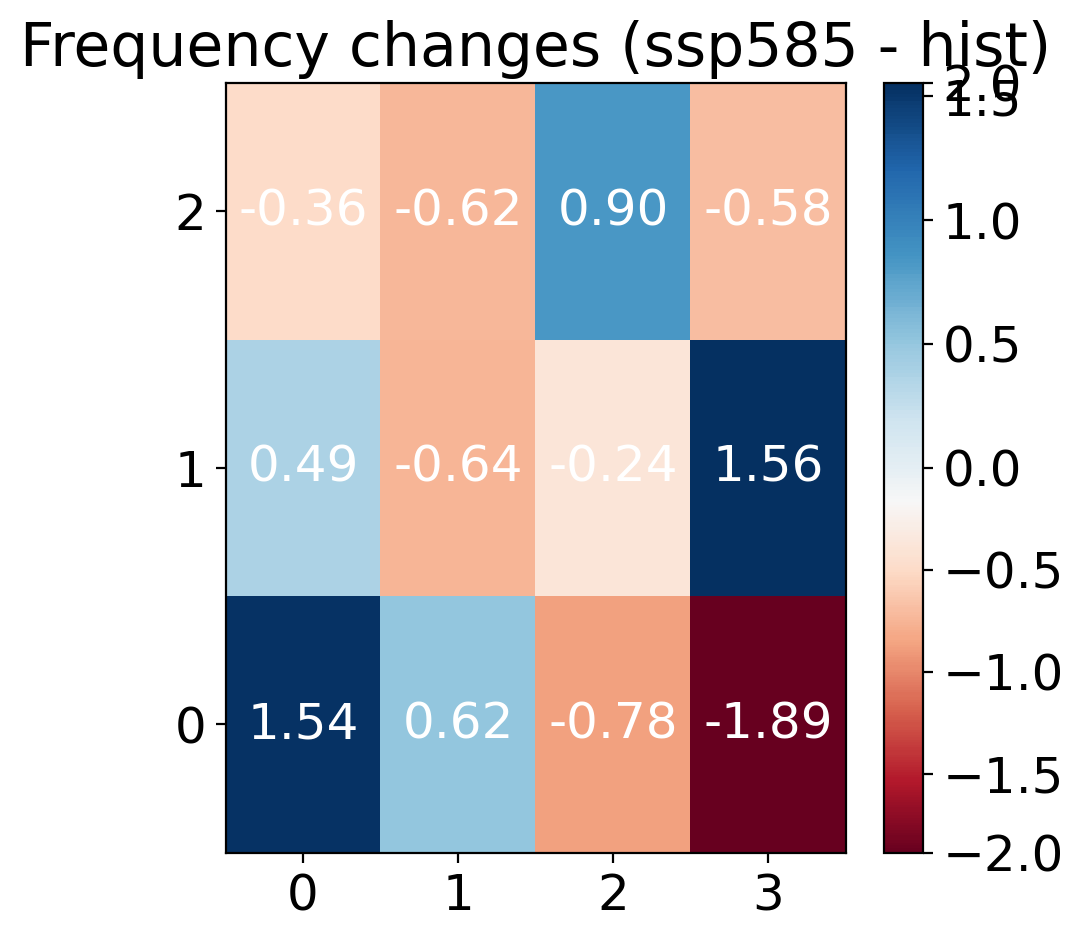

In [723]:
# Plot frequencies for each node
#difs = ssp_freq.T - percent_freq
difs = ssp_freq.T - hist_freq.T
plt.figure(figsize=(5, 5),dpi=200)
plt.pcolor(difs, cmap='RdBu', norm=MidpointNormalize(midpoint=0))
plt.xticks(ticks = np.arange(0.5,4.5,1),labels=['0','1','2','3'])
plt.yticks(ticks = np.arange(0.5,3.5,1), labels=['0','1','2'])
for i in range(0,3):
    for j in range(0,4):
        plt.text(j + 0.5, i + 0.5, f'{difs[i, j]:.2f}', ha='center', va='center', color='w')
plt.colorbar()
plt.title('Frequency changes (ssp585 - hist)')
#plt.savefig('freq_changes_ssp585-hist_'+run+'.png')
plt.show()